# Predicting clothes size 

Choosing the right size of a t-shirt or of trousers could be challenging task, especially if one buys them online. There are myriad number of merchants offering clothes on the Internet. Most of them have size comparison tables and return policy if the product turned out to be the wrong size. However, sending it back and waiting for item with the right size could be rather boring. In general, it is believed that a person's height, weight, and age are reliable predictors for a garment's size.

Kaggle has published a large [dataset](https://www.kaggle.com/tourist55/clothessizeprediction) for clothes’ size prediction. It is explored and modelled in this Notebook. It has 119734 samples (rows) and 4 features (columns): "weights" (kgs), "age", "height" (cm), and size. At first glance, it seems the classification task would be quite a simple task since common sense suggests that a shirt's or pants' size depends on person's body measurements. However, it turned out that this logic is wrong.

#### Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, confusion_matrix

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

In [5]:
plt.style.use("ggplot")

## I. Load data

Raw data are loaded and stored in `measures_data`. The dataset has 119734 rows and 4 columns. The head rows are displayed below.

In [6]:
measures_data = pd.read_csv("data/final_test.csv")

In [7]:
measures_data.shape

(119734, 4)

In [8]:
measures_data.head()

,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M


## II. Exploratory Data Analysis

A brief overview shows that there are missing values in the DataFrame. The first three columns contain numeric values, and the last one - strings.

In [9]:
measures_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119734 entries, 0 to 119733
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   weight  119734 non-null  int64  
 1   age     119477 non-null  float64
 2   height  119404 non-null  float64
 3   size    119734 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


### II.1. Explore distributions

The function below plots the distribution of values with their mean and median in all numeric features.

In [10]:
def plot_histogram(dataset, feature):
    """
    Function: Plots columns with numeric values.
    
    Parameters: dataset and a target column.
    """
    plt.hist(dataset[feature], bins = 20, color = "teal")
    plt.axvline(dataset[feature].mean(), color = "red", label = "mean")
    plt.axvline(dataset[feature].median(), color = "orange", label = "median")
    
    plt.xlabel(f"{feature}")
    plt.ylabel("Count")
    plt.title(f"Distribution of {feature} in the dataset")
    plt.legend()
    plt.show()

"Weight" values are not distributed normally. It could be seen that most people in the dataset weigh between 40 and 90 kgs. However, both the mean and the median are not around 65 kg but close to 60 kg (see few lines below). 

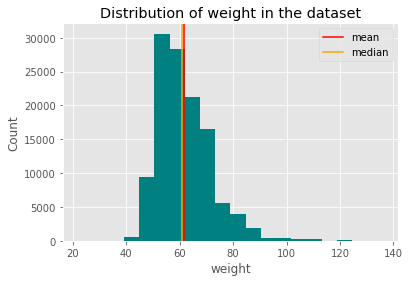

In [11]:
plot_histogram(measures_data, "weight")

Data have been taken from people of various age ranging from 10 to around 70 years. Age distribution is also skewed; the median value is to the left of the mean, which suggests that younger people prevail.

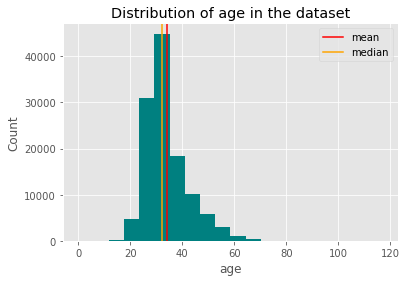

In [12]:
plot_histogram(measures_data, "age")

"Height" values look almost normally distributed. The average person is 1.65 m tall. Half of people are shorter, and the other half - taller. 

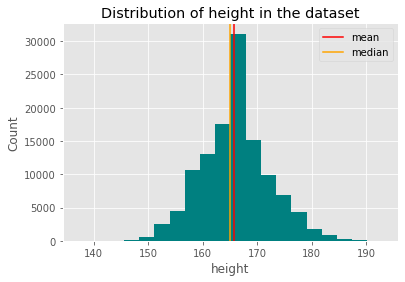

In [13]:
plot_histogram(measures_data, "height")

Means of the three variables are computed below.

In [14]:
measures_data["weight"].mean(), measures_data["age"].mean(), measures_data["height"].mean()

(61.75681093089682, 34.027310695782454, 165.80579427826837)

Items per size category are shown on the figure below. `sns.countplot()` displays categories in descending order according to the number of items in each category, which is a little bit inconvenient for comprehending. For this reason, the function is asked to order them logically (i.e., to start from "XXS" and to end with "XXXL").

In [15]:
def countplot_sizes(dataset):
    """
    Function: Displays number of items in each category.
    
    Parameters: The dataset.
    """
    sns.countplot(x = dataset["size"],
                 order=["XXS","S","M","L","XL","XXL","XXXL"],
                 palette = "crest", data = dataset)
    plt.title("Number of items per category")
    plt.show()

Most people in the dataset wear clothes of size "M". The other common measurements are "S", "L", "XL", and "XXXL". Only a tiny number of people declared they choose "XXL" garments.

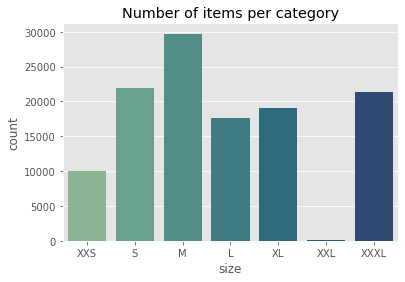

In [16]:
countplot_sizes(measures_data)

In [17]:
measures_data["size"].value_counts()

M       29712
S       21924
XXXL    21359
XL      19119
L       17587
XXS      9964
XXL        69
Name: size, dtype: int64

### II.2. Explore correlation

Correlation shows if and how strong variables are related. The scatter plots below display each pair variables and the direction of their relationship. Plotting 120 000 dots wouldn't be very informative. For this reason, a random sample of 1000 entries is taken out of the dataset and used for exploring correlation.

In [18]:
sample_measures = measures_data.sample(1000)

In [19]:
def plot_correlation(variable_one, variable_two):
    """
    Function: Computes and plots correlation between two variables and shows regression line.
    
    Parameters: Two variables.
    """
    sns.regplot(x = variable_one, y = variable_two, data = sample_measures,
               scatter_kws = {"color": "teal"}, line_kws = {"color": "orange"})
    plt.title(f"Correlation between {variable_one} and {variable_two}")
    plt.show()

There is a positive relationship between "height" and "weight". It seems the taller the person, the heavier he or she is. Dots on the far right show that tall people weigh more than 60 kgs but those around 1.50 m barely reach 55 kgs.

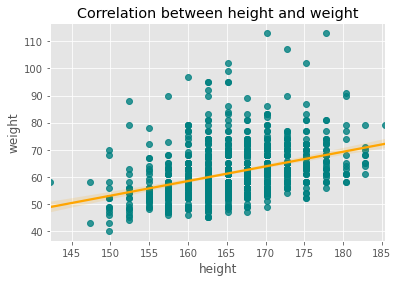

In [20]:
plot_correlation("height", "weight")

Correlation between "age" and "weight" is positive but not so strong. There are people aged both 25 and 50 who weight more than 80 kgs. For this reason, the line slope is not so steep.

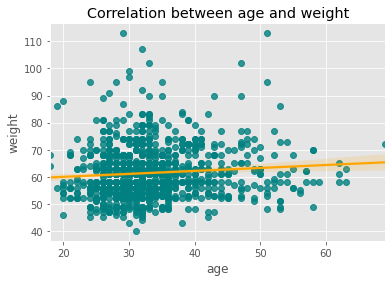

In [21]:
plot_correlation("age", "weight")

Similarly, "age" and "height" are not so linked as well. Tall and shorter people could be of any age. Thus, the last two plots suggest that "age" might not be a good predictor for clothes' size.

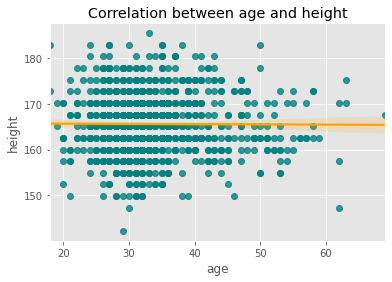

In [22]:
plot_correlation("age", "height")

These observations are confirmed by the matrix below showing the correlation coefficient between each pair of variables. It is computed with all samples found in the dataset. Stronger link between "weight" and "height" is visible in the top-right and bottom-left corners (0.39); lacking correlation between "age" and "weight" and "height" is confirmed by 0.068 and -0.003 coefficients, respectively. Therefore, an attempt was made to model the data without "age" but the classifier didn't perform better than the one with all features.

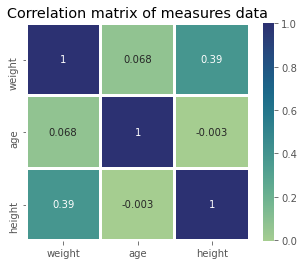

In [23]:
plt.figure(figsize = (5, 4))
sns.heatmap(measures_data.corr(),
           annot = True,
           cmap = "crest",
           linewidths = 2, 
           linecolor = "white")
plt.title("Correlation matrix of measures data")
plt.show()

### II.3 Check for and handle missing values

There are missing values in the "age" and "height" columns. Their number is insignificant (around 600) and for this reason samples without values in these columns were removed. Imputing them is impossible since entering any value (e.g., random, mean or median) might distort distributions.

In [24]:
measures_data.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,119734.0,61.756811,9.944863,22.00,55.00,61.0,67.00,136.00
age,119477.0,34.027311,8.149447,0.00,29.00,32.0,37.00,117.00
height,119404.0,165.805794,6.737651,137.16,160.02,165.1,170.18,193.04


In [25]:
measures_data = measures_data.dropna(subset = ["age"])
measures_data = measures_data.dropna(subset = ["height"])

In [26]:
measures_data.isna().any()

weight    False
age       False
height    False
size      False
dtype: bool

In [27]:
measures_data.shape

(119153, 4)

### II.4 Explore outliers

Outliers are samples with extreme values in either dimension (feature). `describe()` method applied over the dataset above suggests some outliers. For example, a person of 0 years of age (e.g., a baby) hardly could weight more than 10 kgs or be more than 0.60 - 0.70 m (well below the minimum values in the other columns). Also, there are many centenarians in the world but not many of them reach 117 years of age. For this reason, samples where age is less than 5 and more than 100, were removed. Weight of 22 kgs is too little for an adult but not uncommon for a child; also, obese people might weigh well above 110 - 120 kgs. For this reason, extreme values in "weight" column remain in the table as they are. Similarly, it is quite possible a child to be 1.37 m tall and solid people to reach 2.00 m high. Outliers in all three features are shown on the boxplots below.

In [28]:
measures_numerical = measures_data[["weight", "age", "height"]]

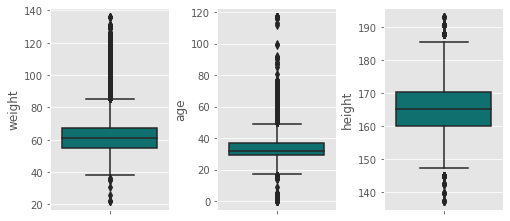

In [29]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (7, 3))
idx = 0
axs = axs.flatten()
for k, v in measures_numerical.items():
    sns.boxplot(y = k, data = measures_numerical, color = "teal", ax = axs[idx])
    idx += 1
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)

The code lines below compute the outliers share. 

In [96]:
print("Outliers outside the upper bound in 'weight' column are {:.2f}%".format((len(measures_data[measures_data['weight'] >= 82]) / len(measures_data))*100))
print("Outliers outside the lower bound in 'weight' column are {:.2f}%".format((len(measures_data[measures_data['weight'] < 40]) / len(measures_data))*100))

Outliers outside the upper bound in 'weight' column are 3.75%
Outliers outside the lower bound in 'weight' column are 0.01%


In [32]:
print("Outliers outside the upper bound in 'age' column are {:.2f}%".format((len(measures_data[measures_data["age"] >= 50]) / len(measures_data))*100))
print("Outliers outside the lower bound in 'age' column are {:.2f}%".format((len(measures_data[measures_data["age"] < 19]) / len(measures_data))*100))

Outliers outside the upper bound in 'age' column are 5.56%
Outliers outside the lower bound in 'age' column are 0.37%


In [33]:
print("Outliers outside the upper bound in 'height' column are {:.2f}%".format((len(measures_data[measures_data["height"] >= 185]) / len(measures_data))*100))
print("Outliers outside the lower bound in 'height' column are {:.2f}%".format((len(measures_data[measures_data["height"] < 148]) / len(measures_data))*100))

Outliers outside the upper bound in 'height' column are 0.28%
Outliers outside the lower bound in 'height' column are 0.17%


Outliers’ share is not high in any feature. Furthermore, it should be stressed here that these extreme values are not in fact real outliers since it is quite possible a person to weigh 90 kgs or to be 65 years of age. For this reason, only values less than or equal to 5 (48 entries) and greater than 100 (34 entries) in "age" are removed. Also, it is interesting to note that there are obvious errors in the data (see the output below). It is impossible a 2 years of age person to weigh 81 kg and to be 1.77 tall (index # 9103).

In [34]:
measures_data[measures_data["age"] <= 5]

,weight,age,height,size
1261,56,0.0,170.18,S
5553,65,3.0,175.26,L
7142,56,0.0,170.18,S
9103,81,2.0,177.80,XXXL
9146,56,0.0,165.10,M
9324,58,0.0,172.72,XL
12926,81,2.0,177.80,XXXL
22046,56,0.0,170.18,S
23593,77,0.0,177.80,XXXL
24858,49,4.0,165.10,S


In [35]:
measures_data = measures_data[(measures_data["age"] <= 100) & (measures_data["age"] > 5)]

Slightly more than 119 000 entries remained in the dataset after removing outliers in "age".

In [36]:
measures_data.shape

(119071, 4)

# III. Data Pre-processing

The dataset is prepared for modelling at this stage. Machine Learning algorithms accept only numeric values; for this reason, "size" column which holds categorical values is encoded. Normally, this is performed with `sklearn’s` `LabelEncoder()` function. To preserve the logical order of garments' size, however, strings are replaced with integers manually.

### III.1. Label Encoding

A brief check shows the manual encoding was successful.

In [37]:
measures_data["size"].replace({"XXS": 0, "S": 1, "M": 2, "L": 3, "XL": 4, "XXL": 5, "XXXL": 6}, inplace = True)

In [38]:
measures_data.head()

,weight,age,height,size
0,62,28.0,172.72,4
1,59,36.0,167.64,3
2,61,34.0,165.10,2
3,65,27.0,175.26,3
4,62,45.0,172.72,2


It is interesting to see distribution of all categories (clothes’ size) against each predicting variable. The function below helps for displaying it.

In [41]:
def plot_cross_distribution(dataset, category, feature):
    """
    Function: Displays distribution of category against a predicting variable (feature).
    
    Parameters: Two variables.
    """
    for idx, data in dataset.groupby(category):
        plt.hist(data[feature], alpha = 0.7, label = idx)
    
        plt.xlabel(f"{feature}")
        plt.ylabel("Number of people")
        plt.title(f"Distribution of cloth {category} against {feature}")
        plt.legend()
    plt.show()

The histogram below shows that "weight" plays a role for determining clothes' size. Heavier people are more likely to buy items of size "XXXL" (category "6)", whereas lighter ones - smaller clothes. Mean of each category is printed below. There is a distance of 25 kgs between the first and the last size category.

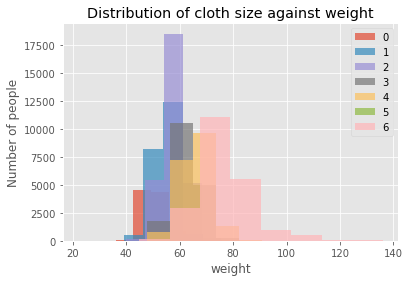

In [42]:
plot_cross_distribution(measures_data, "size", "weight")

In [46]:
measures_data.groupby("size")["weight"].mean()

size
0    50.541844
1    54.109924
2    58.207571
3    62.250243
4    65.577473
5    66.376812
6    75.930945
Name: weight, dtype: float64

On the other hand, people of various "heights" are equally likely to purchase garments of all sizes. "Height" mean per category are given below. The difference between the smallest and the largest size is around 6 cm, which is not so much taking into account minimum and maximum values in the whole dataset (137 and 193, respectively).

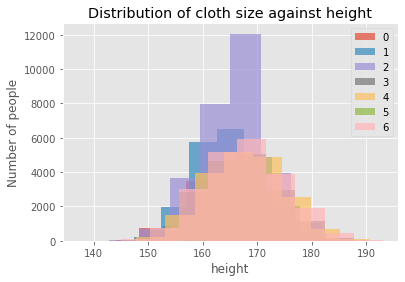

In [43]:
plot_cross_distribution(measures_data, "size", "height")

In [47]:
measures_data.groupby("size")["height"].mean()

size
0    161.320036
1    163.764421
2    165.494563
3    166.946956
4    167.672040
5    160.388116
6    167.837877
Name: height, dtype: float64

It is once again confirmed that "age" does not play a role for determining clothes' size. Mean values of all categories are displayed below. The difference spans between 31.5 and 36.4 years of age, which suggests that both young and older people chose to buy both smaller and larger items.

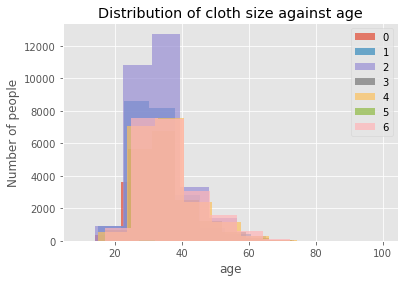

In [44]:
plot_cross_distribution(measures_data, "size", "age")

In [45]:
measures_data.groupby("size")["age"].mean()

size
0    31.545987
1    32.600156
2    33.437976
3    34.228836
4    34.954010
5    36.304348
6    36.435699
Name: age, dtype: float64

### III. 2. Separate labels from features

The code lines below separate features from labels. Both are stored in variables.

In [51]:
features = measures_data.drop(["size"], axis = 1)
labels = measures_data["size"]

### III.3. Scale features

Features are scaled with `MinMaxScaler()`, which makes values to range between 0 and 1.

In [52]:
scaler = MinMaxScaler()

In [53]:
def scale_data(features):
    """
    Function: Scales features within range [0,1].
    
    Parameters: Features.
    
    Returns: Scaled features
    """
    return scaler.fit_transform(features)

In [54]:
features_scaled = scale_data(features)

A brief check confirms the scaling was successful.

In [55]:
features_scaled.min(), features_scaled.max()

(0.0, 1.0)

### III. 4. Split data into Training, Validation, and Testing sets

Both features and labels are split into training, validation, and testing set. The former are used for training and tuning hyper-parameters, whereas the latter - for testing model's performance. 5% of data are kept aside for validation, and the same number - for testing. It is better to have more data for training; thus, the algorithm will see and learn more relationships.

In [56]:
trval_features, test_features, trval_labels, test_labels = train_test_split(features_scaled, labels,
                                                            test_size = 0.05, stratify = labels)

In [57]:
train_features, val_features, train_labels, val_labels = train_test_split(trval_features, trval_labels,
                                                            test_size = len(test_labels), stratify = trval_labels)

A brief check confirms the dataset was properly split. Slightly less than 6000 entries are withheld for validation and for testing; the remaining are used for training.

In [58]:
train_features.shape, train_labels.shape, val_features.shape, val_labels.shape, test_features.shape, test_labels.shape

((107163, 3), (107163,), (5954, 3), (5954,), (5954, 3), (5954,))

It is important labels in all sets to have similar distribution. The function below helps for checking if this is so.

In [59]:
def display_labels(labels, title = None):
    """
    Function: Displays number of items in each category.
    
    Parameters: Labels.
    """
    sns.countplot(x = labels,
                order = [0, 1, 2, 3, 4, 5, 6],
                palette = "crest", data = labels)
    if title is not None:
        plt.title(title)
plt.show()

The three plots below confirm that the share of each label in all three sets is similar. Providing more samples to the algorithm helps for improving model's performance. An attempt was made to train a `sklearn` classifier and a Neural Network with a balanced dataset (by levelling up all categories) but it was futile. Models' accuracy didn't improve.

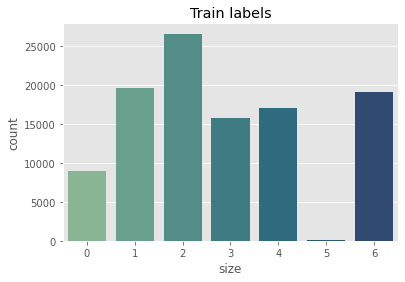

In [60]:
display_labels(train_labels, "Train labels")

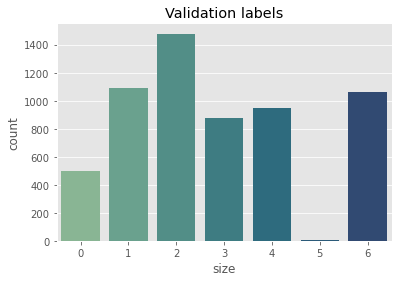

In [61]:
display_labels(val_labels, "Validation labels")

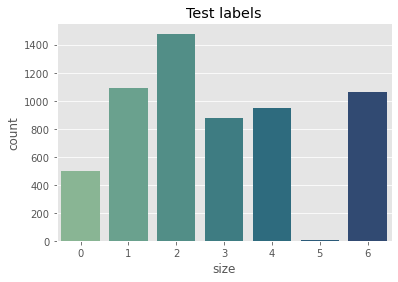

In [62]:
display_labels(test_labels, "Test labels")

## IV. Predicting clothes' size with Random Forest

Various classifiers were tried and tested to solve this problem. Logistic Regression proved to be high biased and the SVM - too slow. The code lines below explore the best combination of hyper-parameters for `DecisionTreeClassifier()` and `RandomForestClassifier()`. AdaBoost was also tested but didn't show higher accuracy or f1 score.

In [63]:
f1 = make_scorer(f1_score , average = "weighted")

In [64]:
pipe = Pipeline(steps = [("estimator", DecisionTreeClassifier())])

In [65]:
params_all = [{
            "estimator": [DecisionTreeClassifier()],
            "estimator__max_depth": [10, 15, 20],
            "estimator__min_samples_leaf": [5, 10]
            },
            {
            "estimator": [RandomForestClassifier()],
            "estimator__n_estimators": [10, 15, 20],
            "estimator__max_depth": [10, 15, 20]
            }]

In [66]:
grid_search = GridSearchCV(pipe, param_grid = params_all, scoring = f1, cv = 5)

In [67]:
grid_search.fit(train_features, train_labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('estimator',
                                        DecisionTreeClassifier())]),
             param_grid=[{'estimator': [DecisionTreeClassifier()],
                          'estimator__max_depth': [10, 15, 20],
                          'estimator__min_samples_leaf': [5, 10]},
                         {'estimator': [RandomForestClassifier(max_depth=15,
                                                               n_estimators=20)],
                          'estimator__max_depth': [10, 15, 20],
                          'estimator__n_estimators': [10, 15, 20]}],
             scoring=make_scorer(f1_score, average=weighted))

`RandomForestClassifier()` with 20 estimators each 15 levels deep seems to return best results. 

In [68]:
grid_search.best_params_

{'estimator': RandomForestClassifier(max_depth=15, n_estimators=20),
 'estimator__max_depth': 15,
 'estimator__n_estimators': 20}

In [69]:
random_forest_model = RandomForestClassifier(n_estimators = 20, max_depth = 15)

Training, category prediction and model evaluation are wrapped in a function for sparing time and for avoiding repeated operations. It returns "accuracy" and "f1 score" on the respective set of data.

In [70]:
def classification_task(estimator, features, labels):
    """
    Function: "fit", "predict" and "score" values of an estimator.
    
    Parameters: estimator, features (X) and labels (y).
    
    Returns: model's performance measured as accuracy and f1_score.
    """
    estimator.fit(features, labels)
    predictions = estimator.predict(features)
    
    print(f"Accuracy: {accuracy_score(labels, predictions)}")
    print(f"F1 score: {f1_score(labels, predictions, average = 'weighted')}")

Random Forest failed to reach 60% accuracy on the training data. However, its performance on validation and testing sets is much better, which could be explained with the smaller number of samples there.

In [71]:
# Train data
classification_task(random_forest_model, train_features, train_labels)

Accuracy: 0.5839982083368327
F1 score: 0.5801174313500264


In [72]:
# Validation data
classification_task(random_forest_model, val_features, val_labels)

Accuracy: 0.7621766879408801
F1 score: 0.7618374125127146


In [74]:
# Testing data
classification_task(random_forest_model, test_features, test_labels)

Accuracy: 0.7682230433322136
F1 score: 0.7681864183248994


`classification_report` provides much clearer picture of model's performance. It does really well on samples of category "6" ("XXXL") and much worse on entries of type "3" ("L)".

In [76]:
print(classification_report(test_labels, random_forest_model.predict(test_features)))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74       495
           1       0.74      0.77      0.75      1090
           2       0.72      0.78      0.75      1478
           3       0.71      0.66      0.69       874
           4       0.76      0.75      0.76       951
           5       1.00      0.75      0.86         4
           6       0.91      0.89      0.90      1062

    accuracy                           0.77      5954
   macro avg       0.81      0.75      0.78      5954
weighted avg       0.77      0.77      0.77      5954



Confusion matrix visualizes proper and wrong predictions. Rows show predicted labels (sizes) and columns - the actual ones. For example, most garments of the largest size were properly classified. However, some were predicted as "XXXL" but in reality they are either "S", "M", and so forth.

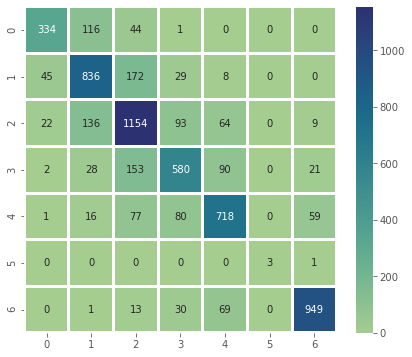

In [77]:
plt.style.use("ggplot")
plt.figure(figsize = (7, 6))
sns.heatmap(confusion_matrix(test_labels, random_forest_model.predict(test_features)),
        annot = True,
        fmt = ".0f",
        cmap = "crest",
        linewidths = 2, 
        linecolor = "white",
        xticklabels = random_forest_model.classes_,
        yticklabels = random_forest_model.classes_)
plt.show()

Artificial Neural Networks are much more powerful than classical algorithms. The next Chapter explores if a Neural Network could better predict clothes’ size.

## V. Predicting cloths' size with a Neural Network

In [78]:
INPUT = train_features.shape[1]
OUTPUT = len(set(train_labels))

In [79]:
tf.keras.backend.clear_session()

This model is not so complex. It has slightly more than 20000 trainable parameters. Several attempts were made to predict garments' size with much more complex net (e.g., with more layers and more neurons) but they were not successful, either. All explored models returned similar results. For this reason, the performance of a much simpler one is displayed below.

In [80]:
nn_model = Sequential([
    Input(shape = INPUT),
    Dense(32, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(32, activation = "relu"),
    Dense(OUTPUT, activation = "softmax")
])

In [81]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 231       
Total params: 21,127
Trainable params: 21,127
Non-trainable params: 0
____________________________________________________

Learning rate was lowered for reducing loss and for improving accuracy but of no avail. 

In [82]:
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                                loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [83]:
history = nn_model.fit(train_features, train_labels,
                      epochs = 50, 
                      validation_data = (val_features, val_labels), verbose = 0)

In [84]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])
    plt.show()

Both training and validation loss couldn't fall below 1.10. At the same time, accuracy fluctuates around 50 - 52%. Training with more epochs (e.g., 100) didn't improve model’s performance.

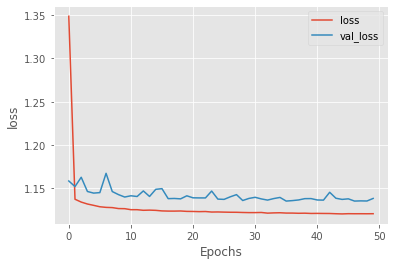

In [85]:
plot_graphs(history, "loss")

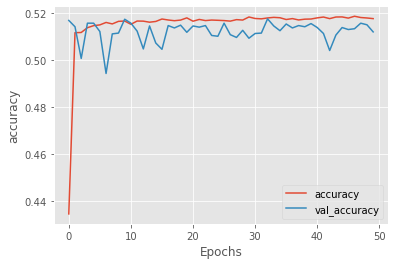

In [86]:
plot_graphs(history, "accuracy")

Performance on the testing data is similar and is not better than the one reached by `RandomForestClassifier()`.

In [97]:
print("Model loss on testing set: {:.2f}".format(nn_model.evaluate(test_features, test_labels)[0]))
print("Model accuracy on testing set: {:.2f}".format(nn_model.evaluate(test_features, test_labels)[1]))

5954/5954 [==============================] - 0s 42us/sample - loss: 1.1121 - accuracy: 0.5197
Model loss on testing set: 1.11
5954/5954 [==============================] - 0s 41us/sample - loss: 1.1121 - accuracy: 0.5197
Model accuracy on testing set: 0.52


## Conclusion

This simple (at first sight) classification task turned out to be a rather complex one. Common sense suggests that a person's weight and height determine the size of his or her clothes. However, both models didn't prove this hypothesis. Various techniques were applied for improving models' performance, including (1) removing "age" column from the dataset, (2) balancing size categories, (3) and removing outliers in all columns. Polynomial Transformation was also tried but it didn't help either. Random Forest hardly surpassed 75% accuracy. A complex Neural Net couldn't go beyond 52% accuracy, too.

The reason for these poor results is simple and was evident in the exploratory stage: there are tall but slim people who need to buy clothes of larger size; and vice versa: there are shorter but obese persons, who might also go for XXL or XXXL. And finally, the outlier detection step showed that there are errors in the dataset, which further complicated the classification task.